# Supervised Contrastive Learning

## Introduction

Supervised Contrastive Learning is performed in two phases:

1. Training an encoder to learn to produce vector representations of input images such
that representations of images in the same class will be more similar compared to
representations of images in different classes.
2. Training a classifier on top of the frozen encoder.


## Setup

In [1]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Prepare the data

In [11]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

num_classes = 10
input_shape = (32, 32, 1)  # Adjusted input shape to 32x32

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Function to resize images
def resize_images(images):
    resized_images = np.zeros((images.shape[0], 32, 32, 1))
    for i in range(images.shape[0]):
        img = array_to_img(images[i].reshape(28, 28, 1), scale=False)
        img = img.resize((32, 32))
        resized_images[i] = img_to_array(img)  # Convert back to array
    return resized_images

# Resize and reshape images
x_train = resize_images(x_train)
x_test = resize_images(x_test)

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (60000, 32, 32, 1) - y_train shape: (60000,)
x_test shape: (10000, 32, 32, 1) - y_test shape: (10000,)


## Using image data augmentation

In [12]:
## Using image data augmentation

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),  # Optional as symmetry is less relevant here
        layers.RandomRotation(0.02),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

## Build the encoder model

In [23]:
def create_encoder():
    base_model = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = base_model(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="fashion_mnist-encoder")
    return model

encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 256  # Adjusted batch size for more typical value
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

Model: "fashion_mnist-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 1)         3         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23558528  
                                                                 
Total params: 23558531 (89.87 MB)
Trainable params: 23513088 (89.70 MB)
Non-trainable params: 45443 (177.52 KB)
_________________________________________________________________


## Build the classification model

In [24]:
import keras
from keras import layers

## Create the classifier model
def create_classifier(encoder, trainable=True):
    # Set the encoder layers to be trainable as specified
    for layer in encoder.layers:
        layer.trainable = trainable

    # Define the input and forward pass
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    # Compile the classifier
    model = keras.Model(inputs=inputs, outputs=outputs, name="fashion_mnist-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

## Train the baseline classification model

In [25]:
# First, create the encoder
encoder = create_encoder()

num_epochs = 24

# Now create the classifier using this encoder
classifier = create_classifier(encoder)
classifier.summary()

# Train the model
history = classifier.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)

# Evaluate the model on the test set
accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Model: "fashion_mnist-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 fashion_mnist-encoder (Fun  (None, 2048)              23558531  
 ctional)                                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                          

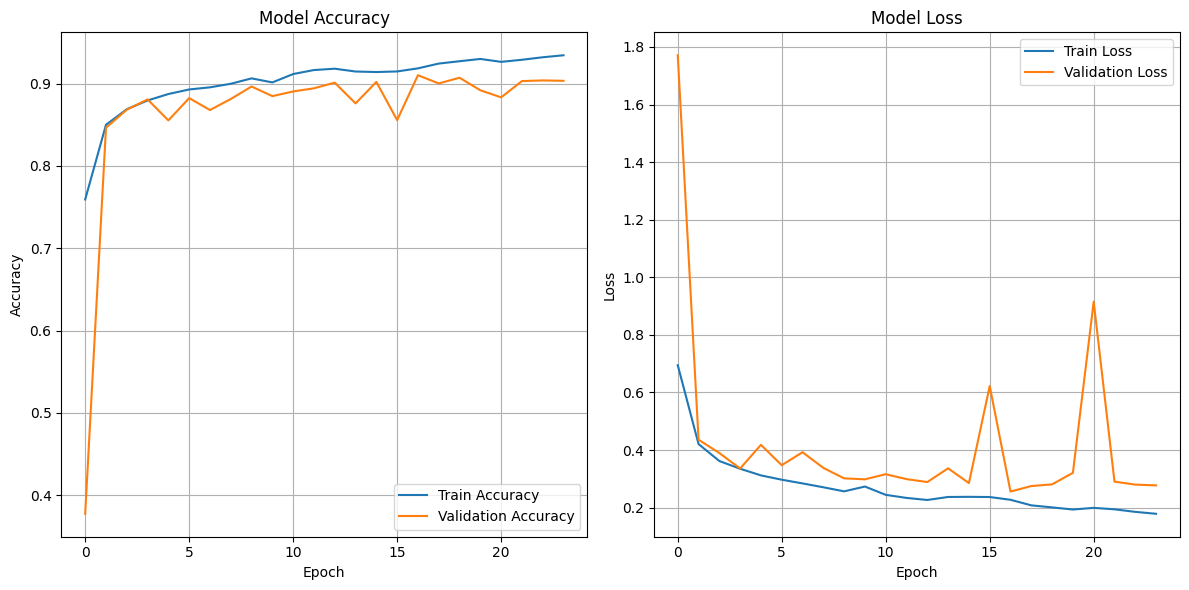

In [26]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 2: Use supervised contrastive learning



In [18]:
import tensorflow_addons as tfa

class TripletSemiHardLoss(keras.losses.Loss):
    def __init__(self, margin=1.0, name="triplet_semi_hard_loss"):
        super().__init__(name=name)
        self.margin = margin

    def call(self, y_true, y_pred, sample_weight=None):
        # TensorFlow Addons' triplet semi-hard loss doesn't use sample_weight, so we ignore it.
        return tfa.losses.triplet_semihard_loss(y_true, y_pred, self.margin)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="encoder_with_projection_head"
    )
    return model

### 2. Pretrain the encoder

In [19]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=TripletSemiHardLoss(margin=1.0),
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    x_train, y_train, batch_size=batch_size, epochs=num_epochs
)

Model: "encoder_with_projection_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 fashion_mnist-encoder (Fun  (None, 2048)              23558531  
 ctional)                                                        
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
Total params: 23820803 (90.87 MB)
Trainable params: 23775360 (90.70 MB)
Non-trainable params: 45443 (177.52 KB)
_________________________________________________________________
Epoch 1/50
235/235 [==============================] - 55s 122ms/step - loss: 0.2546
Epoch 2/50
235/235 [==============================] - 25s 106ms/step - loss: 0.1171
Epoch 3/50
235/235 [==

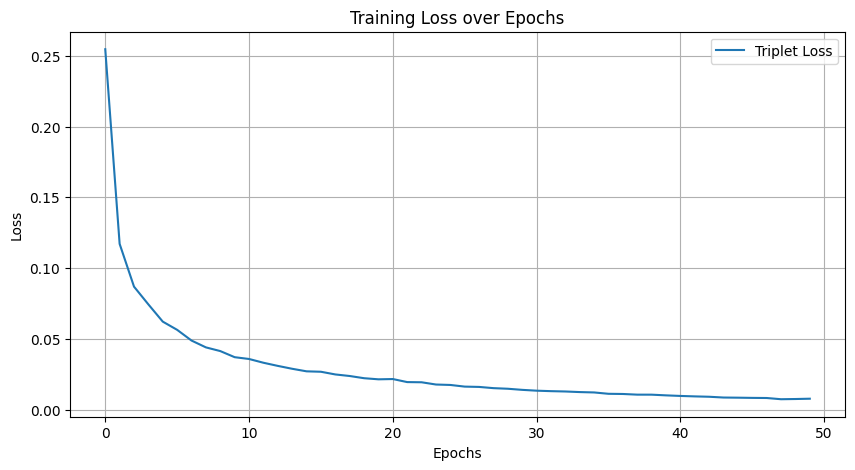

In [20]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Triplet Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 3. Train the classifier with the frozen encoder

In [21]:
classifier = create_classifier(encoder, trainable=False)

num_epochs = 24

history = classifier.fit(
    x_train, y_train, batch_size=batch_size, epochs=num_epochs
)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/24
235/235 [==============================] - 12s 26ms/step - loss: 0.1864 - sparse_categorical_accuracy: 0.9530
Epoch 2/24
235/235 [==============================] - 6s 25ms/step - loss: 0.1357 - sparse_categorical_accuracy: 0.9592
Epoch 3/24
235/235 [==============================] - 6s 25ms/step - loss: 0.1334 - sparse_categorical_accuracy: 0.9588
Epoch 4/24
235/235 [==============================] - 6s 24ms/step - loss: 0.1301 - sparse_categorical_accuracy: 0.9591
Epoch 5/24
235/235 [==============================] - 6s 25ms/step - loss: 0.1275 - sparse_categorical_accuracy: 0.9596
Epoch 6/24
235/235 [==============================] - 6s 24ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.9600
Epoch 7/24
235/235 [==============================] - 6s 25ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.9597
Epoch 8/24
235/235 [==============================] - 6s 24ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.9598
Epoch 9/24
235/235 [===================

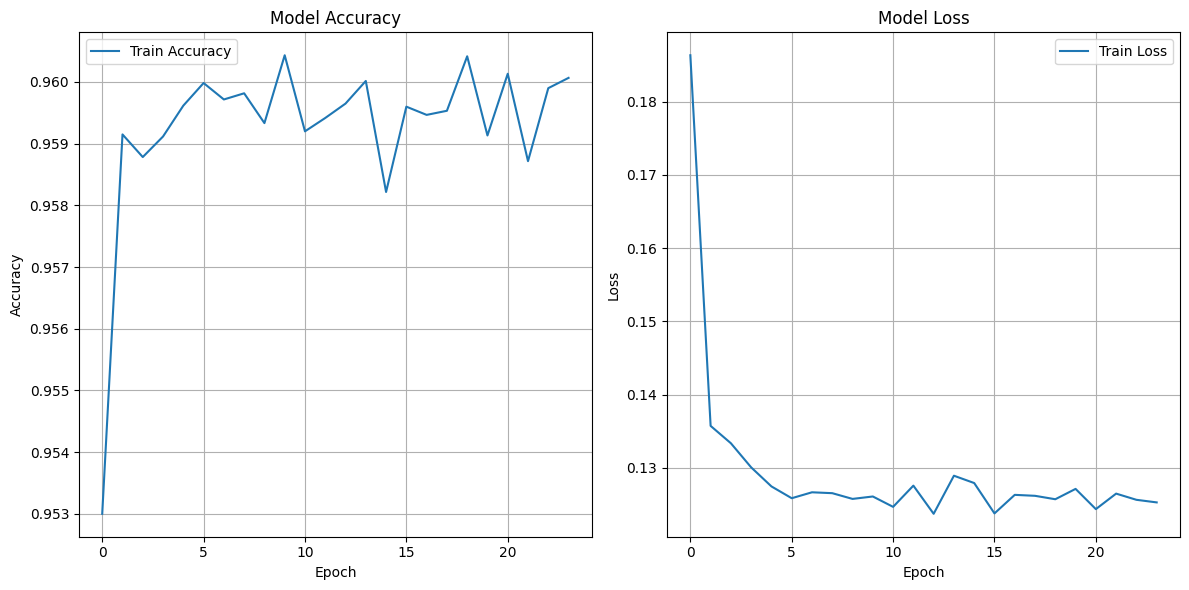

In [22]:
# Plotting the training accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting the training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

We get to an improved test accuracy.